In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Arial'
from matplotlib.dates import DateFormatter

In [21]:
def process_data(filename,major_money=100000):
    """
    filname：传入的文件路径，包含了逐笔成交的信息
    major_money:自定义主力资金的界限
    return:主力资金净流入的分布和当天的分时图
    """
    df=pd.read_excel(filename)
    df.columns=df.columns.str.lower()
    df['time']=pd.to_datetime(df['time'],format='%H:%M:%S')
    # 添加一个固定的日期，例如 '2024-03-26'
    df['time'] = pd.to_datetime('2024-04-10 ' + df['time'].dt.strftime('%H:%M:%S'))
    #添加一个辅助列
    df['minute']=df['time'].dt.to_period('T')

    #划分主力资金和非主力资金
    df['major'] = df['amount'].apply(lambda x: '主力' if x > major_money else '非主力')
    # 计算资金的净流入
    df['net_amount'] = df.apply(lambda row: row['amount'] if row['type'] == '买盘' else -row['amount'], axis=1)
    df_main=df[df['major']=='主力']
    df_main_net_flow=df_main.groupby('minute')['net_amount'].sum()
    df_main_net_flow.index=df_main_net_flow.index.to_timestamp()
    df_main_net_flow.name='net_amount'


    # 画分时图，按分钟分组，并计算每个时间段的开盘价、收盘价、最高价、最低价、成交量和成交金额
    df_minute = df.groupby('minute').agg({'price': ['first', 'last', 'max', 'min'], 
                                          'volume': 'sum'})
    # 重命名列名
    df_minute.columns = ['open', 'close', 'high', 'low', 'volume']

    #把索引转化为时间序列
    df_minute.index = df_minute.index.to_timestamp()
    return df_main_net_flow,df_minute


In [14]:
main_net_flow,minute_price=process_data(r"D:\沪深300股票\2024-4-10\000002.SZ.xlsx")

In [15]:
import matplotlib.pyplot as plt

def plot_example(df, span=50):
    """
    span是横坐标的间隔，默认值为1000
    """
    # 创建数据副本
    df1 = df.copy()
    
    df1['DateStr'] = df1.index.strftime('%m-%d %H:%M')
    
    # 创建子图
    fig, ax1 = plt.subplots(figsize=(10, 6))
    
    # 绘制股票收盘价走势
    ax1.plot(df1['DateStr'], df1['close'], label='股票', color='red')

    
    # 创建共享x轴的第二个y轴，绘制volume柱状图
    ax2 = ax1.twinx()
    ax2.bar(df1['DateStr'], df1['volume'], alpha=1, width=0.1, align='center', label='volume', color='orange')  # 调整 bar 的宽度
    
    # 调整图例位置
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    
    # 添加坐标轴标签和标题
    ax1.set_xlabel('时间')
    ax1.set_ylabel('收盘价')
    ax2.set_ylabel('成交量')
    plt.xticks(np.arange(0, len(df1), span), df1['DateStr'].iloc[::span])
    plt.xticks(rotation=45)  # 旋转 x 轴标签，以免重叠
    
    plt.show()



In [16]:
import matplotlib.pyplot as plt

def plot_net_amount_and_price(df_net_amount, df_price):
    """
    绘制净额走势图和股价波动图
    
    Parameters:
        df_net_amount (DataFrame): 包含了时间和净额的DataFrame，其中索引为时间，列名为NET_AMOUNT。
        df_price (DataFrame): 包含了时间和股价的DataFrame，其中索引为时间，列名为PRICE。
    """
    # 创建图形窗口
    fig, ax1 = plt.subplots(figsize=(12, 6))
    df1 = df_price.copy()
    df1['ewa']=df1['close'].ewm(span=20,adjust=False).mean()
    df2=df_net_amount.copy()
    df2=df2.ewm(span=20,adjust=False).mean()
    #绘制净额走势图
    ax1.plot(df2.index, df2.values, color='blue', linestyle='-', linewidth=2, markersize=6, label='Net Amount')
    ax1.set_ylabel('Net Amount')
    ax1.legend(loc='upper left')
    
    # 创建第二个y轴，绘制股价波动图
    ax2 = ax1.twinx()
    ax2.plot(df1.index, df1['ewa'], color='red', linestyle='-', linewidth=2, markersize=6, label='Price')
    ax2.set_ylabel('Price')
    ax2.legend(loc='upper right')
    
    # 添加标题和标签
    plt.title('Net Amount and Price Comparison')
    plt.xlabel('Time')
    
    # 设置日期格式
    date_form = DateFormatter("%m-%d %H:%M")
    ax1.xaxis.set_major_formatter(date_form)
    
    # 自动调整x轴刻度标签
    fig.autofmt_xdate()
    # 自动调整x轴刻度标签
    plt.xticks(rotation=45)
#     plt.xticks(np.arange(0, len(df_price), span), df1.index.iloc[::span])
    # 显示图形
    plt.grid(True)
    plt.tight_layout()
    plt.show()


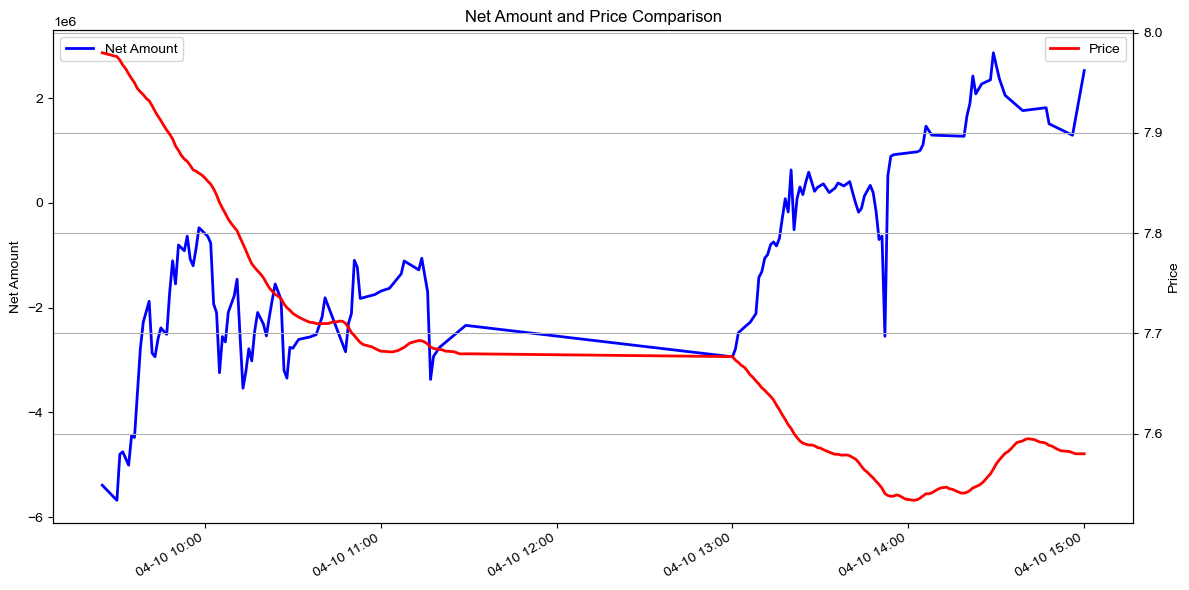

In [17]:
plot_net_amount_and_price(main_net_flow, minute_price)

In [18]:
import pandas as pd
from scipy.stats import pearsonr

# 假设 main_net_flow 和 minute_price 是包含相同索引的 pandas Series
# 如果它们长度不同，我们需要先对它们进行对齐

# 使用内部连接对齐两个 Series（索引应为日期时间）
close=minute_price['close']
close=close.ewm(span=15,adjust=False).mean()
main_net_flow=main_net_flow.ewm(span=15,adjust=False).mean()
combined_df = pd.concat([main_net_flow, close], axis=1, join='inner')
combined_df.columns = ['Net Amount', 'Stock Price']

# 计算皮尔逊相关系数
correlation_coefficient, p_value = pearsonr(combined_df['Net Amount'], combined_df['Stock Price'])

# 输出结果
print(f"皮尔逊相关系数为: {correlation_coefficient}")
print(f"p值为: {p_value}")

# 如果 p值小于 0.05，我们可以得出相关性在统计上是显著的
if p_value < 0.05:
    print("相关性在统计上是显著的。")
else:
    print("相关性在统计上不是显著的。")


皮尔逊相关系数为: -0.6945182424469407
p值为: 4.746865522608749e-22
相关性在统计上是显著的。


In [22]:
import os
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
import glob

# 新函数，用于计算p值和皮尔逊相关系数
def calculate_correlation(folder_path):
    # 获取文件夹中所有文件的路径
    files = glob.glob(f"{folder_path}/*.xlsx")
    correlations = []
    p_values = []
    files_with_p_value_above_threshold = []

    # 遍历文件，计算相关系数
    for file in files:
        # 跳过小于100KB的文件
        if os.path.getsize(file) < 100 * 1024:
            print(f"文件 {file} 小于100KB，已跳过。")
            continue

        main_net_flow, minute_price = process_data(file)
        # 使用内部连接对齐两个 Series（索引应为日期时间）
        #去噪
        close=minute_price['close']
        close=close.ewm(span=20,adjust=False).mean()
        main_net_flow=main_net_flow.ewm(span=20,adjust=False).mean()
        combined_df = pd.concat([main_net_flow, close], axis=1, join='inner')
        combined_df.columns = ['Net Amount', 'Stock Price']

        # 计算皮尔逊相关系数
        correlation_coefficient, p_value = pearsonr(combined_df['Net Amount'], combined_df['Stock Price'])
        correlations.append(correlation_coefficient)
        p_values.append(p_value)

        # 输出当前文件的相关系数和p值
        print(f"文件 {file} 的相关系数为: {correlation_coefficient}")
        print(f"文件 {file} 的p值为: {p_value}")

        

    return correlations,p_values

# 调用函数
folder_path = r"D:\沪深300股票\2024-4-10"
correlation, p_value= calculate_correlation(folder_path)
print(f"所有文件的平均相关系数: {avg_correlation}")
print(f"所有文件的平均p值: {avg_p_value}")
print(f"p值大于0.05的文件有: {files_with_high_p_value}")


文件 D:\沪深300股票\2024-4-10\000001.SZ.xlsx 的相关系数为: 0.2348824019490594
文件 D:\沪深300股票\2024-4-10\000001.SZ.xlsx 的p值为: 0.0002723927700567527
文件 D:\沪深300股票\2024-4-10\000002.SZ.xlsx 的相关系数为: -0.7997784186396573
文件 D:\沪深300股票\2024-4-10\000002.SZ.xlsx 的p值为: 1.916975812875143e-54
文件 D:\沪深300股票\2024-4-10\000063.SZ.xlsx 的相关系数为: -0.692484187967999
文件 D:\沪深300股票\2024-4-10\000063.SZ.xlsx 的p值为: 1.3228162982477064e-35
文件 D:\沪深300股票\2024-4-10\000100.SZ.xlsx 的相关系数为: 0.27710831272945874
文件 D:\沪深300股票\2024-4-10\000100.SZ.xlsx 的p值为: 1.3237575266147032e-05
文件 D:\沪深300股票\2024-4-10\000157.SZ.xlsx 的相关系数为: 0.7391923484901277
文件 D:\沪深300股票\2024-4-10\000157.SZ.xlsx 的p值为: 1.6989416035992129e-40
文件 D:\沪深300股票\2024-4-10\000166.SZ.xlsx 的相关系数为: 0.18547850665856347
文件 D:\沪深300股票\2024-4-10\000166.SZ.xlsx 的p值为: 0.016735704157545456
文件 D:\沪深300股票\2024-4-10\000301.SZ.xlsx 的相关系数为: 0.5841488883338595
文件 D:\沪深300股票\2024-4-10\000301.SZ.xlsx 的p值为: 1.4799572758218047e-15
文件 D:\沪深300股票\2024-4-10\000333.SZ.xlsx 的相关系数为: -0.1450682764439

文件 D:\沪深300股票\2024-4-10\300122.SZ.xlsx 的相关系数为: -0.8037037566877681
文件 D:\沪深300股票\2024-4-10\300122.SZ.xlsx 的p值为: 6.705329733710708e-55
文件 D:\沪深300股票\2024-4-10\300124.SZ.xlsx 的相关系数为: -0.10276250010869861
文件 D:\沪深300股票\2024-4-10\300124.SZ.xlsx 的p值为: 0.11383577921422984
文件 D:\沪深300股票\2024-4-10\300142.SZ.xlsx 的相关系数为: -0.6117242952176907
文件 D:\沪深300股票\2024-4-10\300142.SZ.xlsx 的p值为: 7.378606238768743e-20
文件 D:\沪深300股票\2024-4-10\300223.SZ.xlsx 的相关系数为: -0.02352011981588641
文件 D:\沪深300股票\2024-4-10\300223.SZ.xlsx 的p值为: 0.7268605372650886
文件 D:\沪深300股票\2024-4-10\300274.SZ.xlsx 的相关系数为: 0.234916466450152
文件 D:\沪深300股票\2024-4-10\300274.SZ.xlsx 的p值为: 0.00024082320880991747
文件 D:\沪深300股票\2024-4-10\300308.SZ.xlsx 的相关系数为: -0.7402021552962806
文件 D:\沪深300股票\2024-4-10\300308.SZ.xlsx 的p值为: 4.386052382192426e-43
文件 D:\沪深300股票\2024-4-10\300316.SZ.xlsx 的相关系数为: 0.5274640321014383
文件 D:\沪深300股票\2024-4-10\300316.SZ.xlsx 的p值为: 4.449648020091371e-16
文件 D:\沪深300股票\2024-4-10\300347.SZ.xlsx 的相关系数为: -0.27238675936511514

NameError: name 'avg_correlation' is not defined

In [48]:
type(correlation)

list

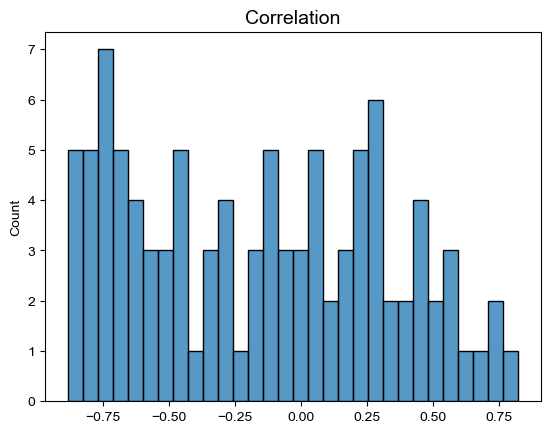

In [24]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# 假设 correlation 是已经存在的数据
correlation = pd.Series(correlation)

# 使用 bins 参数设置更多的区间
sns.histplot(correlation, bins=30)  # 例如这里设置为30个区间

plt.title('Correlation', fontsize=14)
plt.show()


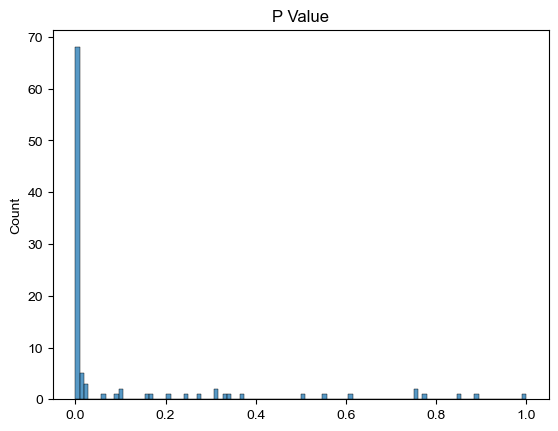

In [14]:
p_value=pd.Series(p_value)
sns.histplot(p_value)
plt.title('P Value')
plt.show()

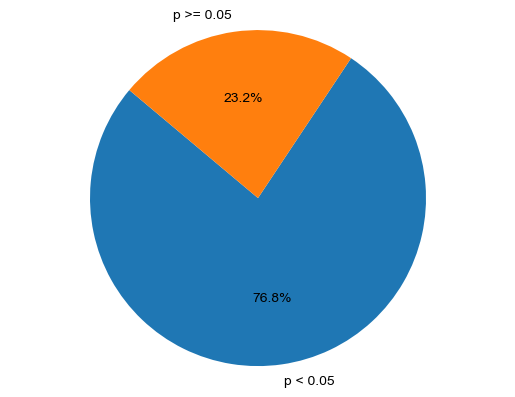

In [15]:
import matplotlib.pyplot as plt
import pandas as pd



# 计算p值小于0.05的占比
p_value_less_than_0_05 = (p_value < 0.05).sum()
p_value_greater_or_equal_0_05 = (p_value >= 0.05).sum()

# 数据准备
sizes = [p_value_less_than_0_05, p_value_greater_or_equal_0_05]
labels = ['p < 0.05', 'p >= 0.05']

# 绘制饼图
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# 显示图表
plt.show()
